In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric_temporal.nn.recurrent import A3TGCN2
from model.model import TemporalGNN
import os   
from tqdm import tqdm

In [3]:
x = np.load('./results/x.npy')
xt = np.load('./results/xt.npy')
y = np.load('./results/y.npy')
yt = np.load('./results/yt.npy')
x = np.transpose(x,(0,2,3,1))
y = np.transpose(y,(0,2,1))

In [4]:

DEVICE = torch.device('cuda') # cuda
shuffle=True
batch_size = 128


In [5]:
train_input = np.array(x) # (27399, 207, 2, 12)
train_target = np.array(y) # (27399, 207, 12)
train_x_tensor = torch.from_numpy(train_input).type(torch.FloatTensor).to(DEVICE)  # (B, N, F, T)
train_target_tensor = torch.from_numpy(train_target).type(torch.FloatTensor).to(DEVICE)  # (B, N, T)
train_dataset_new = torch.utils.data.TensorDataset(train_x_tensor, train_target_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset_new, batch_size=batch_size, shuffle=shuffle,drop_last=True)

xt = np.transpose(xt,(0,2,3,1))
yt = np.transpose(yt,(0,2,1))
test_input = np.array(xt) # (, 207, 2, 12)
test_target = np.array(yt) # (, 207, 12)
test_x_tensor = torch.from_numpy(test_input).type(torch.FloatTensor).to(DEVICE)  # (B, N, F, T)
test_target_tensor = torch.from_numpy(test_target).type(torch.FloatTensor).to(DEVICE)  # (B, N, T)
test_dataset_new = torch.utils.data.TensorDataset(test_x_tensor, test_target_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset_new, batch_size=batch_size, shuffle=shuffle,drop_last=True)


In [6]:
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import A3TGCN2



class TemporalGNN(torch.nn.Module):
    def __init__(self, node_features, periods, batch_size):
        super(TemporalGNN, self).__init__()
        # Attention Temporal Graph Convolutional Cell
        self.tgnn = A3TGCN2(in_channels=3,
                           out_channels=64,
                           periods=periods,
                           batch_size=batch_size
                           ) # node_features=4, periods=12
        # Equals single-shot prediction
        self.linear = torch.nn.Linear(64, periods)

    def forward(self, x, edge_index):
        """
        x = Node features for T time steps
        edge_index = Graph edge indices
        """
        x_selected = x[:, :, :3, :]
        h = self.tgnn(x_selected, edge_index) # x [b, 105, 4, 12]  returns h [b, 105, 12]
        h = F.relu(h)
        h = self.linear(h)
        return h


In [7]:
model = TemporalGNN(node_features=3, periods=12, batch_size=batch_size).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss()


In [8]:
static_edge_index = np.load('./results/edgeidx.npy')
static_edge_index = torch.tensor(static_edge_index, dtype=torch.int)
static_edge_index = static_edge_index.to(torch.long).to(DEVICE)

In [9]:
epochs=5
model.train()
epoch_loss_list = []
test_loss_list = []
for epoch in range(epochs):
    step = 0
    loss_list = []
    #y_hat = y_pred    ,  labels = y
    for encoder_inputs, labels in tqdm(train_loader, desc="Epoch {} train".format(epoch+1)):
        y_hat = model(encoder_inputs, static_edge_index)         # Get model predictions
        loss = loss_fn(y_hat, labels) # Mean squared error #loss = torch.mean((y_hat-labels)**2)  sqrt to change it to rmse
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        step= step+ 1
        loss_list.append(loss.item())

    train_loss = sum(loss_list) / len(loss_list)
    epoch_loss_list.append(train_loss)
    print("Epoch {} train loss: {:.6f} ".format(epoch+1, train_loss))


Epoch 1 train: 100%|██████████| 593/593 [01:00<00:00,  9.83it/s]


Epoch 1 train loss: 0.850243 


Epoch 2 train: 100%|██████████| 593/593 [00:59<00:00,  9.90it/s]


Epoch 2 train loss: 0.713009 


Epoch 3 train: 100%|██████████| 593/593 [00:58<00:00, 10.20it/s]


Epoch 3 train loss: 0.614512 


Epoch 4 train: 100%|██████████| 593/593 [00:59<00:00, 10.05it/s]


Epoch 4 train loss: 0.555885 


Epoch 5 train: 100%|██████████| 593/593 [01:00<00:00,  9.78it/s]

Epoch 5 train loss: 0.522153 


In [ ]:
model.eval()
step = 0
# Store for analysis
total_loss = []
for encoder_inputs, labels in test_loader:
        y_hat = model(encoder_inputs, static_edge_index)
        loss = loss_fn(y_hat, labels)
        total_loss.append(loss.item())

    
test_loss = sum(total_loss) / len(total_loss)
test_loss_list.append(test_loss)

print("Epoch {}  Test Loss :{:.6f}".format(epoch+1,test_loss))


In [10]:
# 将 GPU 上的张量复制到主机内存
encoder_inputs_cpu = encoder_inputs.cpu()
y_hat_cpu = y_hat.cpu()
labels_cpu = labels.cpu()

# 转换为 NumPy 数组
encoder_inputs_numpy = encoder_inputs_cpu.detach().numpy()
y_hat_numpy = y_hat_cpu.detach().numpy()
labels_numpy = labels_cpu.detach().numpy()
# 转换为 NumPy 数组
np.save('./results/train/x.npy', encoder_inputs_numpy)
np.save('./results/train/y_pred.npy', y_hat_numpy)
np.save('./results/train/y_True.npy', labels_numpy)

In [15]:
x = np.load('./results/train/x.npy')
y_pred = np.load('./results/train/y_pred.npy')
y_true = np.load('./results/train/y_True.npy')
print(x.shape)
print(y_pred.shape)
print(y_true.shape)

(128, 105, 4, 12)
(128, 105, 12)
(128, 105, 12)


In [12]:
import numpy as np
repeated_y = np.expand_dims(y_hat.cpu().detach().numpy(), axis=-1) 
y_pred = np.repeat(repeated_y, repeats=4, axis=-1)  #转化为预测值 (128,105,12,4)
feature_1 = y_pred[..., 0] #h
feature_2 = y_pred[..., 1] #qu
feature_3 = y_pred[..., 2] #qd
print(feature_1.shape)
repeated_yreal = np.expand_dims(labels.cpu().detach().numpy(), axis=-1) 
y_real = np.repeat(repeated_yreal, repeats=4, axis=-1)  #转化为预测值   
feature_11 = y_real[..., 0] #h
feature_22 = y_real[..., 1] #qu
feature_33 = y_real[..., 2] #qd
print(feature_11.shape)

(128, 105, 12)
(128, 105, 12)


Text(0.5, 1.0, 'Flooding')

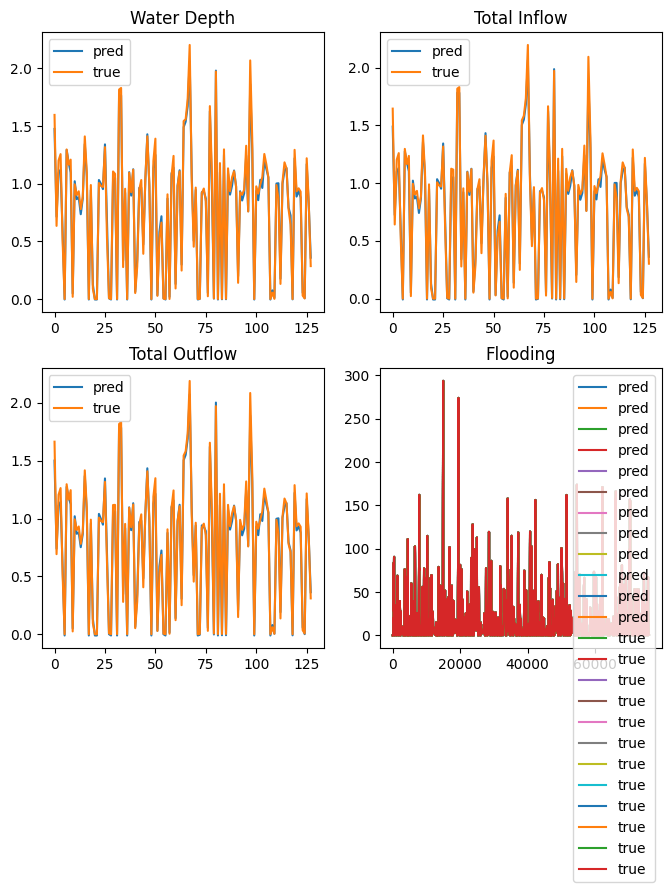

In [14]:
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(8,8))
seq = -1

ax1.plot(feature_1.mean(axis=1)[:,0],label='pred')
ax1.plot(feature_11.mean(axis=1)[:,0],label='true')
ax1.legend()
ax1.set_title('Water Depth')

ax2.plot(feature_2.mean(axis=1)[:,1],label='pred')
ax2.plot(feature_22.mean(axis=1)[:,1],label='true')
ax2.legend()
ax2.set_title('Total Inflow')

ax3.plot(feature_3.mean(axis=1)[:,2],label='pred')
ax3.plot(feature_33.mean(axis=1)[:,2],label='true')
ax3.legend()
ax3.set_title('Total Outflow')

ax4.plot(x.mean(axis=1)[:,-1],label='pred')
ax4.plot(x.mean(axis=1)[:,-1],label='true')
ax4.legend()
ax4.set_title('Flooding')

(128, 105, 4, 12)
(128, 105, 12)
(128, 105, 12)


In [60]:
sensor = 55
timestep = 11
if sensor < y_pred.shape[0] and timestep < y_pred.shape[1]:
    preds = np.asarray([pred[sensor, timestep] for pred in y_pred])
else:
    print("索引超出了数组范围")

if sensor < y_true.shape[0] and timestep < y_true.shape[1]:
    labs = np.asarray([label[sensor, timestep] for label in y_true])
else:
    print("索引超出了数组范围")

<AxesSubplot: >

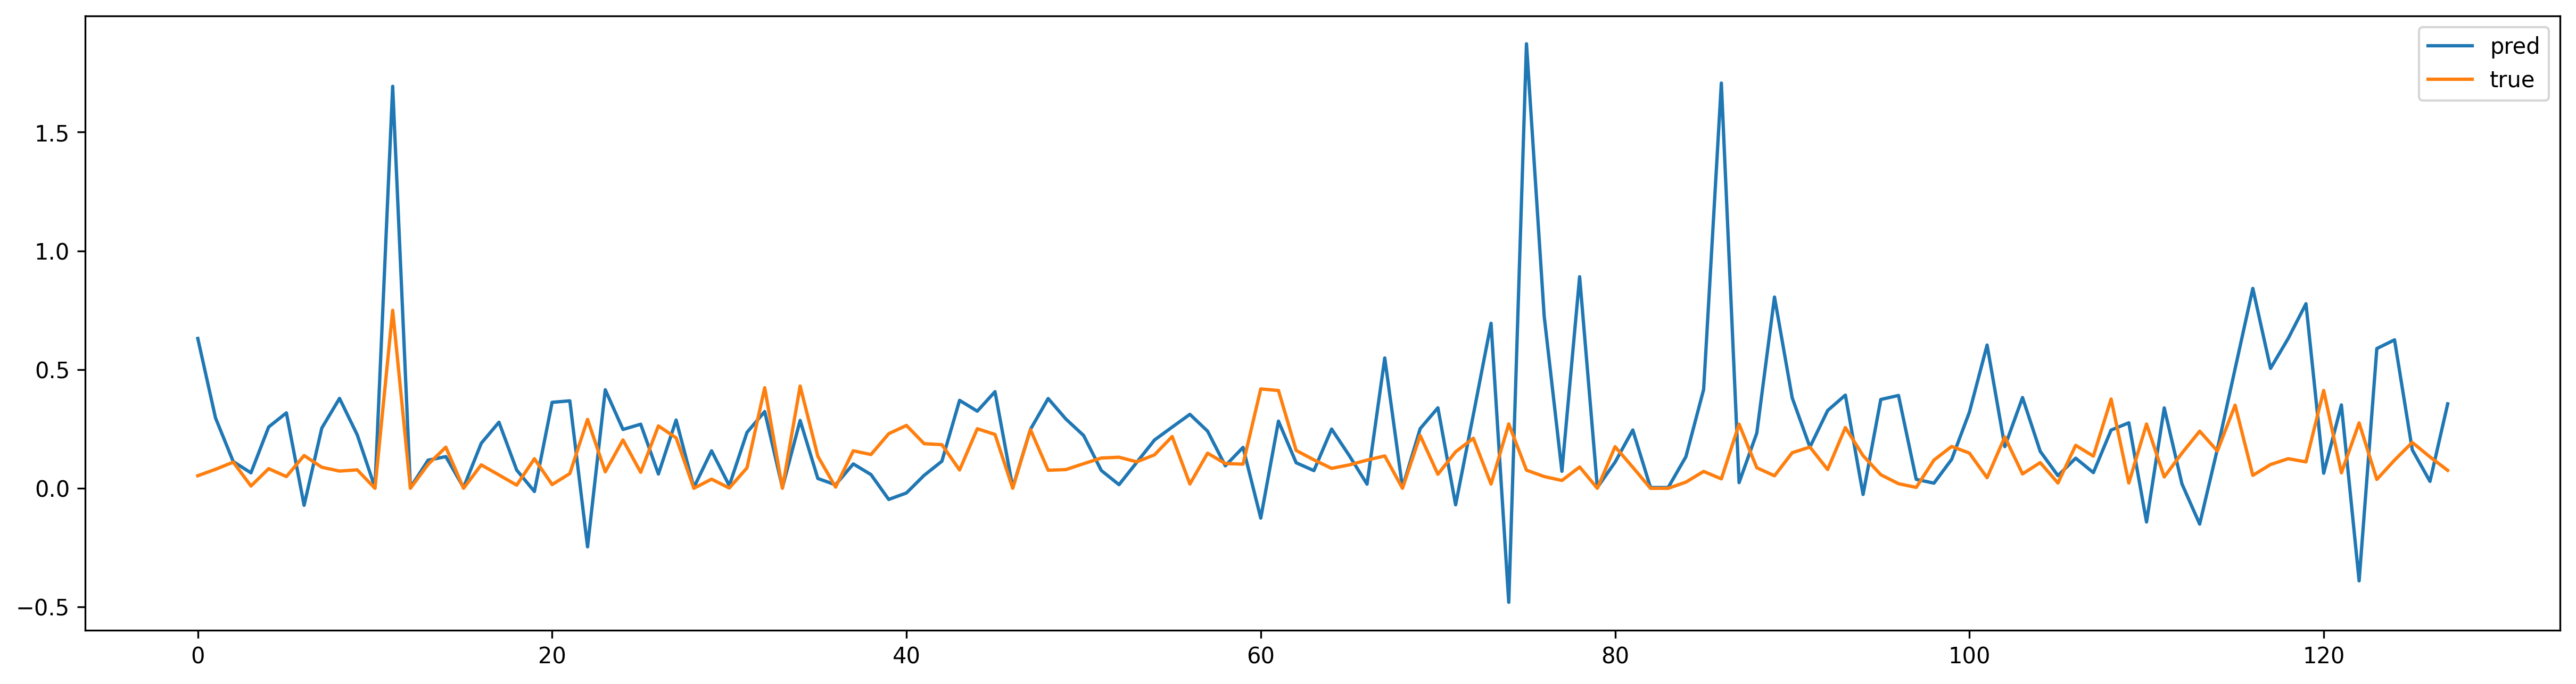

In [61]:
plt.figure(figsize=(20,5),dpi=300)
sns.lineplot(data=preds, label="pred")
sns.lineplot(data=labs, label="true")

Rainfalls